# Public Goods Simulation Visualizer
This notebook reads simulation summary data and snapshot JSON to visualize cooperation dynamics.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import re
import tikzplotlib
import os
from pathlib import Path

os.makedirs("figures", exist_ok=True)
model_to_plot = "A"   # or "B"

FNAME_RE = re.compile(
    r"r(?P<r0>\d{2})v(?P<sigma>\d{3})_(?P<ftype>[^_]+)_L(?P<L>\d+)_(?P<model>A|B)(?:_tau(?P<tau>\d+))?_summary\.csv$"
)

SEED_DIR_RE = re.compile(r"seed(?P<seed>\d{3})$")

def parse_meta(path: str):
    m = FNAME_RE.search(os.path.basename(path))
    if not m:
        return None
    r0 = int(m.group("r0"))/10.0
    sigma = int(m.group("sigma"))/100.0
    ftype = m.group("ftype")
    L = int(m.group("L"))
    model = m.group("model")
    tau = int(m.group("tau")) if m.group("tau") else 0
    alpha = round(sigma / r0, 4)
    return dict(r0=r0, sigma=sigma, ftype=ftype, L=L, model=model, tau=tau, alpha=alpha)

def parse_seed_from_path(path: str):
    # expect .../data/seedXXX/filename.csv
    p = Path(path)
    # look at the parent directory (seed folder)
    m = SEED_DIR_RE.match(p.parent.name)
    return int(m.group("seed")) if m else None

# --- collect files from all seed folders ---
files = sorted(glob.glob("data/seed*/*_summary.csv"))

rows = []
for f in files:
    meta = parse_meta(f)
    if not meta:
        continue
    if model_to_plot and meta["model"] != model_to_plot:
        continue

    df = pd.read_csv(f)
    if "C" not in df.columns and "Cooperator" in df.columns:
        df = df.rename(columns={"Cooperator":"C"})
    if "time" not in df.columns:
        df["time"] = np.arange(len(df))

    # attach metadata
    for k, v in meta.items():
        df[k] = v

    seed = parse_seed_from_path(f)
    df["seed"] = seed

    rows.append(df)

if not rows:
    raise RuntimeError("No matching CSV files found under data/seedXXX/. Check paths and model_to_plot.")

df_all = pd.concat(rows, ignore_index=True)

# Per-run (per-seed) final state
df_final_all = (
    df_all.sort_values("time")
          .groupby(["r0","sigma","alpha","ftype","L","model","tau","seed"], as_index=False)
          .tail(1)
          .reset_index(drop=True)          # clean 0..N index
          .drop(columns=["time"], errors="ignore")  # remove 'time' if present
)

# If you want to aggregate across seeds later (mean ± std):
# df_final_agg = (df_final
#                 .groupby(["r0","sigma","alpha","ftype","L","model","tau"], as_index=False)
#                 .agg(C_mean=("C","mean"), C_std=("C","std"), n=("C","size")))

df_final_all = df_final_all.reset_index(drop=True)
df_final_all


,C,mean_payoff,var_payoff,r0,sigma,ftype,L,model,tau,alpha,seed
0,0.0000,0.00000,0.00000,2.0,0.20,uniform,100,A,0,0.1,3
1,0.0000,0.00000,0.00000,2.0,0.60,uniform,100,A,0,0.3,3
2,0.0000,0.00000,0.00000,2.0,0.40,uniform,100,A,0,0.2,3
3,0.0000,0.00000,0.00000,2.5,0.75,uniform,100,A,0,0.3,9
4,0.0000,0.00000,0.00000,3.0,0.60,uniform,100,A,0,0.2,9
...,...,...,...,...,...,...,...,...,...,...,...
695,0.9628,19.26640,5.41158,5.0,0.50,uniform,100,A,0,0.1,2
696,0.9515,19.06510,37.07980,5.0,2.50,uniform,100,A,0,0.5,8
697,0.3784,5.03749,24.76240,3.5,1.05,uniform,100,A,0,0.3,5
698,0.2893,3.73334,20.23300,3.5,0.70,uniform,100,A,0,0.2,19


In [25]:
import numpy as np

group_keys = ["r0","sigma","alpha","ftype","L","model","tau"]

def agg_block(g):
    # C: average final cooperation fraction across seeds
    C_mean = g["C"].mean()

    # mean_payoff: average across seeds
    m_pay = g["mean_payoff"].mean()

    # var_payoff: pooled across seeds (equal L^2 per seed)
    mean_of_vars = g["var_payoff"].mean()
    var_of_means = ((g["mean_payoff"] - m_pay)**2).mean()  # population variance
    v_pay = mean_of_vars + var_of_means

    return pd.Series({
        "C": C_mean,
        "mean_payoff": m_pay,
        "var_payoff": v_pay,
        "n_seeds": g["seed"].nunique()
    })

df_final = df_final_all.groupby(group_keys, as_index=False).apply(agg_block)
df_final = df_final.reset_index(drop=True)
df_final

,r0,sigma,alpha,ftype,L,model,tau,C,mean_payoff,var_payoff,n_seeds
0,2.0,0.20,0.1,uniform,100,A,0,0.000000,0.000000,0.000000,20.0
1,2.0,0.40,0.2,uniform,100,A,0,0.000000,0.000000,0.000000,20.0
2,2.0,0.60,0.3,uniform,100,A,0,0.000000,0.000000,0.000000,20.0
3,2.0,0.80,0.4,uniform,100,A,0,0.000000,0.000000,0.000000,20.0
4,2.0,1.00,0.5,uniform,100,A,0,0.000000,0.000000,0.000000,20.0
5,2.5,0.25,0.1,uniform,100,A,0,0.000000,0.000000,0.000000,20.0
6,2.5,0.50,0.2,uniform,100,A,0,0.000000,0.000000,0.000000,20.0
7,2.5,0.75,0.3,uniform,100,A,0,0.000000,0.000000,0.000000,20.0
8,2.5,1.00,0.4,uniform,100,A,0,0.000000,0.000000,0.000000,20.0
9,2.5,1.25,0.5,uniform,100,A,0,0.000000,0.000000,0.000000,20.0


In [26]:
def _arrays(df, x="r0", y1="C", y2="mean_payoff", v2="var_payoff"):
    x = df[x].to_numpy()
    y_c = df[y1].to_numpy()
    y_m = df[y2].to_numpy()
    y_se = np.sqrt(df[v2].to_numpy())
    return x, y_c, y_m, y_se

def _title(model, alpha=None, L=None, tau=None):
    parts = []
    if alpha is not None: parts.append(rf'$\alpha={alpha:.1f}$')
    if L is not None:     parts.append(rf'$L={int(L)}$')
    if model == "B" and tau is not None:
        parts.append(rf'$\tau={tau}$')
        parts.append(r'$\mathrm{Model\ B}$')
    elif model == "A":
        parts.append(r'$\mathrm{Model\ A}$')
    return r',$\quad$ '.join(parts) if parts else None

def _save(fig, path, tikz=False, tikz_kwargs=None):
    if not path: return
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if tikz:
        import tikzplotlib
        tikzplotlib.save(path, **(tikz_kwargs or {}))
    else:
        fig.savefig(path, dpi=200, bbox_inches='tight')

def fig_name_alpha_tau(model, alpha, L, tau=None, ext="tex"):
    if model == "A":
        return f"alpha_{alpha:.1f}_A.{ext}"
    return f"alpha_{alpha:.1f}_tau{int(tau):05d}_B.{ext}"

# --- main plotting function ---
def plot_dual_axis_by_r0(
    df_subset,
    *,
    alpha_value=None, tau_value=None,          # for title/filename
    save_path=None, save_tikz=False,
    x_col="r0", y1_col="C", y2_col="mean_payoff", y2_var_col="var_payoff",
    model_col="model", L_col="L",
    show=True, return_fig=False
):
    if df_subset.empty:
        raise ValueError("df_subset is empty")

    model = str(df_subset[model_col].iloc[0])
    L_val = int(df_subset[L_col].iloc[0]) if L_col in df_subset else None
    x, y_c, y_m, y_se = _arrays(df_subset, x_col, y1_col, y2_col, y2_var_col)

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.set_prop_cycle(None)  # predictable colours

    # left: C (blue)
    ax1.plot(x, y_c, marker='o', markersize=1, linewidth=1.5,
             color='tab:blue', label='Cooperator ratio (C)')
    ax1.set_xlabel(r'$r_0$')
    ax1.set_ylabel('Cooperator Ratio', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(-0.05, 1.05)

    # right: mean payoff (red) + SE
    ax2 = ax1.twinx()
    ax2.set_prop_cycle(None)
    ax2.plot(x, y_m, marker='s', markersize=1, linewidth=1.5,
             color='tab:red', label='Mean payoff')
    ax2.errorbar(x, y_m, yerr=y_se, fmt='none',
                 ecolor='tab:red', alpha=0.5, capsize=3)
    ax2.set_ylabel('Mean Payoff', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    title = _title(model, alpha_value, L_val, tau_value)
    if title: plt.title(title)
    fig.tight_layout()

    _save(fig, save_path, tikz=save_tikz)

    if show:
        from IPython.display import display
        display(fig)
    if return_fig:
        return fig, ax1, ax2
    plt.close(fig)

def render_alpha_plots(df_final, model_to_plot, save_dir="figures", save_tikz=True, show_inline=True):
    import os
    os.makedirs(save_dir, exist_ok=True)

    df = df_final.copy()
    df['tau'] = df.get('tau', 0).fillna(0).astype(int)
    df = df[df['model'] == model_to_plot]
    if df.empty:
        raise ValueError(f"No rows for model={model_to_plot}")

    # Grouping scheme: A -> by alpha; B -> by (alpha, tau>0)
    keys = ['alpha'] if model_to_plot == 'A' else ['alpha', 'tau']

    n = 0
    for key_vals, sub in df.groupby(keys, sort=True):
        # Unpack keys
        if model_to_plot == 'A':
            alpha, tau = float(key_vals[0]), 0
        else:
            alpha, tau = float(key_vals[0]), int(key_vals[1])
            if tau <= 0:  # guard against stray zeros
                continue

        sub = sub.sort_values('r0')
        if sub.empty:
            continue
        L_val = int(sub['L'].iloc[0])

        save_path = os.path.join(
            save_dir,
            fig_name_alpha_tau(model_to_plot, alpha, L_val, tau=tau, ext="tex")
        )

        # Render + save (plot function handles display/close)
        plot_dual_axis_by_r0(
            sub,
            alpha_value=alpha,
            tau_value=tau,
            save_path=save_path,
            save_tikz=save_tikz,
            show=show_inline
        )
        n += 1

    print(f"[done] generated {n} plot(s) for model {model_to_plot} → {save_dir}")

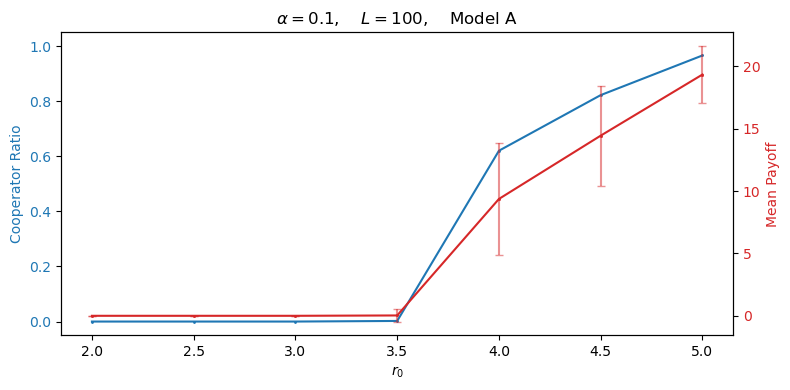

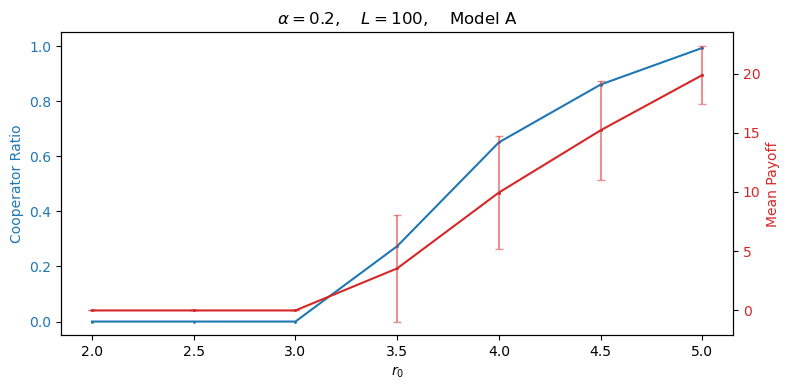

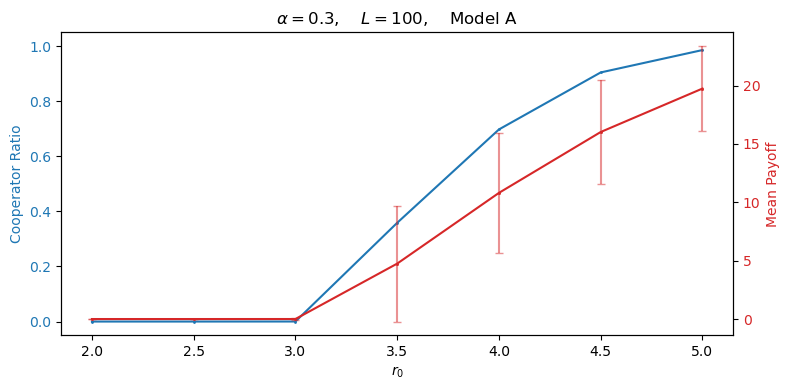

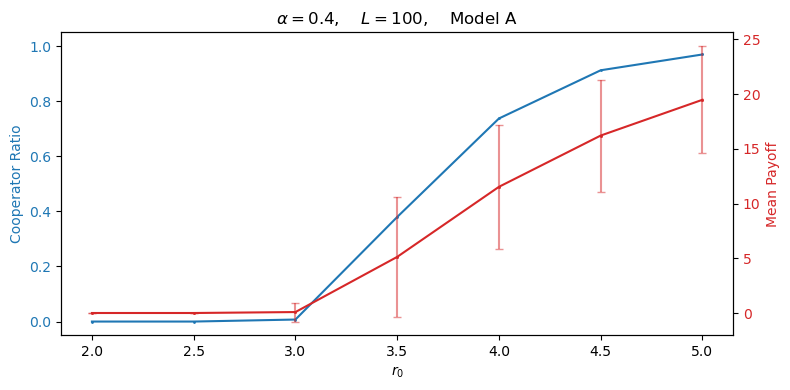

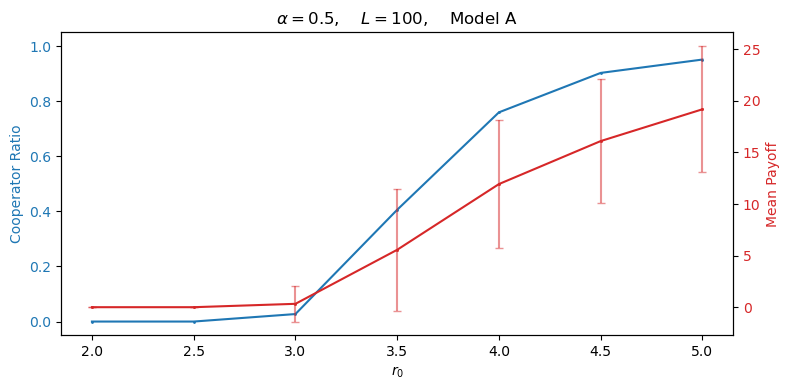

[done] generated 5 plot(s) for model A → figures/A_seed_20


In [27]:
dir_name = "figures/" + model_to_plot + "_seed_20"
render_alpha_plots(df_final, model_to_plot, save_dir=dir_name, save_tikz=True)